# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import math

import json

import re

import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import resample

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from scipy.stats import t

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from itertools import combinations

from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
warnings.filterwarnings("ignore")

np.seterr(all='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/04a_modeling_lr'

# Loading data

In [4]:
path_to_ftir_data = './../data/processed_data/dataset_3800_2500_engineered.csv'
path_to_features_description = './../data/processed_data/features_description_3800_2500.json'

## FTIR-features (*long-list*)

In [5]:
dataset = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(dataset.shape)
dataset.head(3)

(75, 49)


,$I_{2928}$,$I_{3355}$,$I_{3725}$,$\overline{I}_{3800\text{–}2500}$,"$\Sigma I_{p,\ 3800\text{–}2500}$",$\overline{I}_{2928 \pm 50}$,$\overline{I}_{3355 \pm 50}$,$\overline{I}_{3725 \pm 50}$,$\log I_{2928}$,$(I_{2928})^{-1}$,$\log I_{3355}$,$(I_{3355})^{-1}$,$\log I_{3725}$,$(I_{3725})^{-1}$,$\log \overline{I}_{3800\text{–}2500}$,$(\overline{I}_{3800\text{–}2500})^{-1}$,"$\log \Sigma I_{p,\ 3800\text{–}2500}$","$(\Sigma I_{p,\ 3800\text{–}2500})^{-1}$",$\log \overline{I}_{2928 \pm 50}$,$(\overline{I}_{2928 \pm 50})^{-1}$,$\log \overline{I}_{3355 \pm 50}$,$(\overline{I}_{3355 \pm 50})^{-1}$,$\log \overline{I}_{3725 \pm 50}$,$(\overline{I}_{3725 \pm 50})^{-1}$,$\frac{I_{2928}}{I_{3355}}$,$\frac{I_{2928}}{I_{3725}}$,$\frac{I_{2928}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{2928}}{\overline{I}_{3355 \pm 50}}$,$\frac{I_{2928}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3355}}{I_{3725}}$,$\frac{I_{3355}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3355}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3355}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3355}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3725}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3725}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{3355 \pm 50}}{\overline{I}_{3725 \pm 50}}$,Split,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,0.491720,1.0,0.088957,0.526201,1.580676,0.494443,0.982242,0.075964,-0.709847,2.033679,0.0,1.0,-2.419606,11.241429,-0.642072,1.900414,0.457853,0.632641,-0.704324,2.022478,-0.017917,1.018079,-2.577498,13.164155,0.491720,5.527631,0.934471,0.311082,0.500609,6.473072,11.241429,1.900414,0.632641,2.022478,13.164155,0.169054,0.056278,0.179913,0.090565,1.064230,0.535714,6.926993,0.503382,6.508923,12.930390,Train,$> 0$,$d > 5$,2
division_1_size_5,0.406937,1.0,0.028525,0.477909,1.435462,0.396989,0.982472,0.035765,-0.899098,2.457385,0.0,1.0,-3.556968,35.056730,-0.738335,2.092448,0.361487,0.696640,-0.923846,2.518960,-0.017684,1.017841,-3.330798,27.960634,0.406937,14.265868,0.851494,0.283488,0.414197,11.378206,35.056730,2.092448,0.696640,2.518960,27.960634,0.059687,0.019872,0.071854,0.029034,1.203834,0.486436,13.362643,0.404072,11.100072,27.470532,Train,$< 5$,$2 < d \leq 5$,1
division_1_size_3,0.618445,1.0,0.079233,0.535789,1.697678,0.581733,0.981591,0.067710,-0.480547,1.616959,0.0,1.0,-2.535360,12.620970,-0.624015,1.866407,0.529262,0.589040,-0.541743,1.719000,-0.018581,1.018755,-2.692524,14.768908,0.618445,7.805375,1.154270,0.364289,0.630044,9.133756,12.620970,1.866407,0.589040,1.719000,14.768908,0.147881,0.046672,0.136202,0.080719,0.921021,0.545837,7.913018,0.592644,8.591567,14.497024,Train,$< 3$,$2 < d \leq 5$,1


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

# Data wrangling

## Data wrangling

In [7]:
dataset_train = dataset.loc[dataset['Split'] == 'Train']

X_train = dataset_train.loc[:, ~dataset_train.columns.isin(['Split', 'Fraction_hue', 'Fraction_grouped_hue', 'Class'])]
y_train = dataset_train['Class']

print(
    f'(*) X_train: {X_train.shape}',
    f'(*) y_train: {y_train.shape}',
    sep='\n'
)
X_train.head(3)

(*) X_train: (50, 45)
(*) y_train: (50,)


,$I_{2928}$,$I_{3355}$,$I_{3725}$,$\overline{I}_{3800\text{–}2500}$,"$\Sigma I_{p,\ 3800\text{–}2500}$",$\overline{I}_{2928 \pm 50}$,$\overline{I}_{3355 \pm 50}$,$\overline{I}_{3725 \pm 50}$,$\log I_{2928}$,$(I_{2928})^{-1}$,$\log I_{3355}$,$(I_{3355})^{-1}$,$\log I_{3725}$,$(I_{3725})^{-1}$,$\log \overline{I}_{3800\text{–}2500}$,$(\overline{I}_{3800\text{–}2500})^{-1}$,"$\log \Sigma I_{p,\ 3800\text{–}2500}$","$(\Sigma I_{p,\ 3800\text{–}2500})^{-1}$",$\log \overline{I}_{2928 \pm 50}$,$(\overline{I}_{2928 \pm 50})^{-1}$,$\log \overline{I}_{3355 \pm 50}$,$(\overline{I}_{3355 \pm 50})^{-1}$,$\log \overline{I}_{3725 \pm 50}$,$(\overline{I}_{3725 \pm 50})^{-1}$,$\frac{I_{2928}}{I_{3355}}$,$\frac{I_{2928}}{I_{3725}}$,$\frac{I_{2928}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{2928}}{\overline{I}_{3355 \pm 50}}$,$\frac{I_{2928}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3355}}{I_{3725}}$,$\frac{I_{3355}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3355}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3355}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3355}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3725}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3725}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{3355 \pm 50}}{\overline{I}_{3725 \pm 50}}$
division_1_size_bulk,0.491720,1.0,0.088957,0.526201,1.580676,0.494443,0.982242,0.075964,-0.709847,2.033679,0.0,1.0,-2.419606,11.241429,-0.642072,1.900414,0.457853,0.632641,-0.704324,2.022478,-0.017917,1.018079,-2.577498,13.164155,0.491720,5.527631,0.934471,0.311082,0.500609,6.473072,11.241429,1.900414,0.632641,2.022478,13.164155,0.169054,0.056278,0.179913,0.090565,1.064230,0.535714,6.926993,0.503382,6.508923,12.930390
division_1_size_5,0.406937,1.0,0.028525,0.477909,1.435462,0.396989,0.982472,0.035765,-0.899098,2.457385,0.0,1.0,-3.556968,35.056730,-0.738335,2.092448,0.361487,0.696640,-0.923846,2.518960,-0.017684,1.017841,-3.330798,27.960634,0.406937,14.265868,0.851494,0.283488,0.414197,11.378206,35.056730,2.092448,0.696640,2.518960,27.960634,0.059687,0.019872,0.071854,0.029034,1.203834,0.486436,13.362643,0.404072,11.100072,27.470532
division_1_size_3,0.618445,1.0,0.079233,0.535789,1.697678,0.581733,0.981591,0.067710,-0.480547,1.616959,0.0,1.0,-2.535360,12.620970,-0.624015,1.866407,0.529262,0.589040,-0.541743,1.719000,-0.018581,1.018755,-2.692524,14.768908,0.618445,7.805375,1.154270,0.364289,0.630044,9.133756,12.620970,1.866407,0.589040,1.719000,14.768908,0.147881,0.046672,0.136202,0.080719,0.921021,0.545837,7.913018,0.592644,8.591567,14.497024


In [8]:
dataset_test = dataset.loc[dataset['Split'] == 'Test']

X_test = dataset_test.loc[:, ~dataset_test.columns.isin(['Split', 'Fraction_hue', 'Fraction_grouped_hue', 'Class'])]
y_test = dataset_test['Class']

hue_train = dataset_test['Fraction_grouped_hue'].tolist()

print(
    f'(*) X_train: {X_test.shape}',
    f'(*) y_train: {y_test.shape}',
    sep='\n'
)
X_test.head(3)

(*) X_train: (25, 45)
(*) y_train: (25,)


,$I_{2928}$,$I_{3355}$,$I_{3725}$,$\overline{I}_{3800\text{–}2500}$,"$\Sigma I_{p,\ 3800\text{–}2500}$",$\overline{I}_{2928 \pm 50}$,$\overline{I}_{3355 \pm 50}$,$\overline{I}_{3725 \pm 50}$,$\log I_{2928}$,$(I_{2928})^{-1}$,$\log I_{3355}$,$(I_{3355})^{-1}$,$\log I_{3725}$,$(I_{3725})^{-1}$,$\log \overline{I}_{3800\text{–}2500}$,$(\overline{I}_{3800\text{–}2500})^{-1}$,"$\log \Sigma I_{p,\ 3800\text{–}2500}$","$(\Sigma I_{p,\ 3800\text{–}2500})^{-1}$",$\log \overline{I}_{2928 \pm 50}$,$(\overline{I}_{2928 \pm 50})^{-1}$,$\log \overline{I}_{3355 \pm 50}$,$(\overline{I}_{3355 \pm 50})^{-1}$,$\log \overline{I}_{3725 \pm 50}$,$(\overline{I}_{3725 \pm 50})^{-1}$,$\frac{I_{2928}}{I_{3355}}$,$\frac{I_{2928}}{I_{3725}}$,$\frac{I_{2928}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{2928}}{\overline{I}_{3355 \pm 50}}$,$\frac{I_{2928}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3355}}{I_{3725}}$,$\frac{I_{3355}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3355}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3355}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3355}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3725}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3725}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{3355 \pm 50}}{\overline{I}_{3725 \pm 50}}$
division_1_size_0.4,1.000000,0.737033,0.093476,0.510844,1.830509,0.892572,0.731960,0.066062,2.220446e-16,1.00000,-0.305122,1.356791,-2.370049,10.697914,-0.671691,1.957545,0.604594,0.546296,-0.113648,1.120358,-0.312029,1.366195,-2.717162,15.137295,1.356791,10.697914,1.957545,0.546296,1.366195,15.137295,7.884719,1.442776,0.402638,0.825741,11.156690,0.182984,0.051066,0.104727,0.127707,0.572328,0.697912,7.732796,1.219427,13.511122,11.079895
division_1_size_0.2,1.000000,0.361894,0.036618,0.311007,1.398512,0.824054,0.362606,0.029038,0.000000e+00,1.00000,-1.016403,2.763238,-3.307211,27.308853,-1.167940,3.215363,0.335409,0.715045,-0.193520,1.213513,-1.014438,2.757813,-3.539163,34.438086,2.763238,27.308853,3.215363,0.715045,2.757813,34.438086,9.882919,1.163621,0.258771,0.439164,12.462948,0.117741,0.026184,0.044437,0.100986,0.377411,0.857699,10.710483,2.272586,28.378830,12.487463
division_2_size_5,0.381564,1.000000,0.000359,0.435524,1.381923,0.366102,0.979527,0.009970,-9.634757e-01,2.62079,0.000000,1.000000,-7.933009,2787.803089,-0.831206,2.296085,0.323476,0.723629,-1.004843,2.731479,-0.020685,1.020901,-4.608224,100.305878,0.381564,1063.726355,0.876104,0.276111,0.389539,38.273150,2787.803089,2.296085,0.723629,2.731479,100.305878,0.000824,0.000260,0.000980,0.000366,1.189624,0.444627,43.685603,0.373754,36.722185,98.252333


In [9]:
dataset = pd.concat([dataset_train, dataset_test], axis=0)

print(dataset.shape)
dataset.head(3)

(75, 49)


,$I_{2928}$,$I_{3355}$,$I_{3725}$,$\overline{I}_{3800\text{–}2500}$,"$\Sigma I_{p,\ 3800\text{–}2500}$",$\overline{I}_{2928 \pm 50}$,$\overline{I}_{3355 \pm 50}$,$\overline{I}_{3725 \pm 50}$,$\log I_{2928}$,$(I_{2928})^{-1}$,$\log I_{3355}$,$(I_{3355})^{-1}$,$\log I_{3725}$,$(I_{3725})^{-1}$,$\log \overline{I}_{3800\text{–}2500}$,$(\overline{I}_{3800\text{–}2500})^{-1}$,"$\log \Sigma I_{p,\ 3800\text{–}2500}$","$(\Sigma I_{p,\ 3800\text{–}2500})^{-1}$",$\log \overline{I}_{2928 \pm 50}$,$(\overline{I}_{2928 \pm 50})^{-1}$,$\log \overline{I}_{3355 \pm 50}$,$(\overline{I}_{3355 \pm 50})^{-1}$,$\log \overline{I}_{3725 \pm 50}$,$(\overline{I}_{3725 \pm 50})^{-1}$,$\frac{I_{2928}}{I_{3355}}$,$\frac{I_{2928}}{I_{3725}}$,$\frac{I_{2928}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{2928}}{\overline{I}_{3355 \pm 50}}$,$\frac{I_{2928}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3355}}{I_{3725}}$,$\frac{I_{3355}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3355}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3355}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3355}}{\overline{I}_{3725 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3800\text{–}2500}}$,"$\frac{I_{3725}}{\Sigma I_{p,\ 3800\text{–}2500}}$",$\frac{I_{3725}}{\overline{I}_{2928 \pm 50}}$,$\frac{I_{3725}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3355 \pm 50}}$,$\frac{\overline{I}_{2928 \pm 50}}{\overline{I}_{3725 \pm 50}}$,$\frac{\overline{I}_{3355 \pm 50}}{\overline{I}_{3725 \pm 50}}$,Split,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,0.491720,1.0,0.088957,0.526201,1.580676,0.494443,0.982242,0.075964,-0.709847,2.033679,0.0,1.0,-2.419606,11.241429,-0.642072,1.900414,0.457853,0.632641,-0.704324,2.022478,-0.017917,1.018079,-2.577498,13.164155,0.491720,5.527631,0.934471,0.311082,0.500609,6.473072,11.241429,1.900414,0.632641,2.022478,13.164155,0.169054,0.056278,0.179913,0.090565,1.064230,0.535714,6.926993,0.503382,6.508923,12.930390,Train,$> 0$,$d > 5$,2
division_1_size_5,0.406937,1.0,0.028525,0.477909,1.435462,0.396989,0.982472,0.035765,-0.899098,2.457385,0.0,1.0,-3.556968,35.056730,-0.738335,2.092448,0.361487,0.696640,-0.923846,2.518960,-0.017684,1.017841,-3.330798,27.960634,0.406937,14.265868,0.851494,0.283488,0.414197,11.378206,35.056730,2.092448,0.696640,2.518960,27.960634,0.059687,0.019872,0.071854,0.029034,1.203834,0.486436,13.362643,0.404072,11.100072,27.470532,Train,$< 5$,$2 < d \leq 5$,1
division_1_size_3,0.618445,1.0,0.079233,0.535789,1.697678,0.581733,0.981591,0.067710,-0.480547,1.616959,0.0,1.0,-2.535360,12.620970,-0.624015,1.866407,0.529262,0.589040,-0.541743,1.719000,-0.018581,1.018755,-2.692524,14.768908,0.618445,7.805375,1.154270,0.364289,0.630044,9.133756,12.620970,1.866407,0.589040,1.719000,14.768908,0.147881,0.046672,0.136202,0.080719,0.921021,0.545837,7.913018,0.592644,8.591567,14.497024,Train,$< 3$,$2 < d \leq 5$,1


## Base parameters

In [10]:
type_color_dict = {
    '$d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [11]:
groups = list(type_color_dict.keys())

In [12]:
sns.set_theme()

## Dictionary for features mapping to type

In [13]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

## Dictionary for mapping *class* to *size group*

In [14]:
class_fraction_group_dict = {
    0: r'$d \leq 2$',
    1: r'$2 < d \leq 5$',
    2: r'$d > 5$'
}

# Modeling

## Target rate analysis

Mapping hue ~ group:
* Class 0 — $0< d \leq 2$
* Class 1 — $2 < d \leq 5$
* Class 2 — $d > 5$

In [15]:
fractions_hue_train_df = pd.DataFrame(dataset_train['Fraction_hue'].value_counts()).sort_values(by='Fraction_hue')
fractions_hue_test_df = pd.DataFrame(dataset_test['Fraction_hue'].value_counts()).sort_values(by='Fraction_hue')

display(fractions_hue_train_df.T, fractions_hue_test_df.T)

Fraction_hue,$< 0.2$,$< 0.4$,$< 2$,$< 2.5$,$< 25$,$< 3$,$< 4$,$< 5$,$< 50$,$< 70$,$< 75$,$> 0$
count,3,6,6,6,4,6,1,6,1,3,1,7


Fraction_hue,$< 0.2$,$< 0.4$,$< 2$,$< 2.5$,$< 25$,$< 3$,$< 5$,$< 75$,$> 0$
count,4,2,2,2,2,4,4,2,3


In [16]:
target_rate_train_df = pd.DataFrame(dataset_train['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')
target_rate_test_df = pd.DataFrame(dataset_test['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')

display(target_rate_train_df.T, target_rate_test_df.T)

Fraction_grouped_hue,$2 < d \leq 5$,$d > 5$,$d \leq 2$
count,19,16,15


Fraction_grouped_hue,$2 < d \leq 5$,$d > 5$,$d \leq 2$
count,10,7,8


### Data wrangling

In [17]:
train = target_rate_train_df.copy()
test  = target_rate_test_df.copy()

train = train["count"].reset_index()
test  = test["count"].reset_index()
train.columns = ["bin", "count_train"]
test.columns  = ["bin", "count_test"]

bins_order = list(train["bin"])
bins_order += [b for b in test["bin"] if b not in bins_order]

df = (pd.DataFrame({"bin": bins_order})
      .merge(train, on="bin", how="left")
      .merge(test,  on="bin", how="left"))
df[["count_train", "count_test"]] = df[["count_train", "count_test"]].fillna(0).astype(int)

sum_tr, sum_te = df["count_train"].sum(), df["count_test"].sum()
df["freq_train"] = df["count_train"] * 100 / sum_tr if sum_tr else 0
df["freq_test"]  = df["count_test"] * 100  / sum_te if sum_te else 0

### Visualization

In [18]:
fontsize = 14

train_color = "#08519c"
test_color  = "#1f77b4"
edge_color = "white"

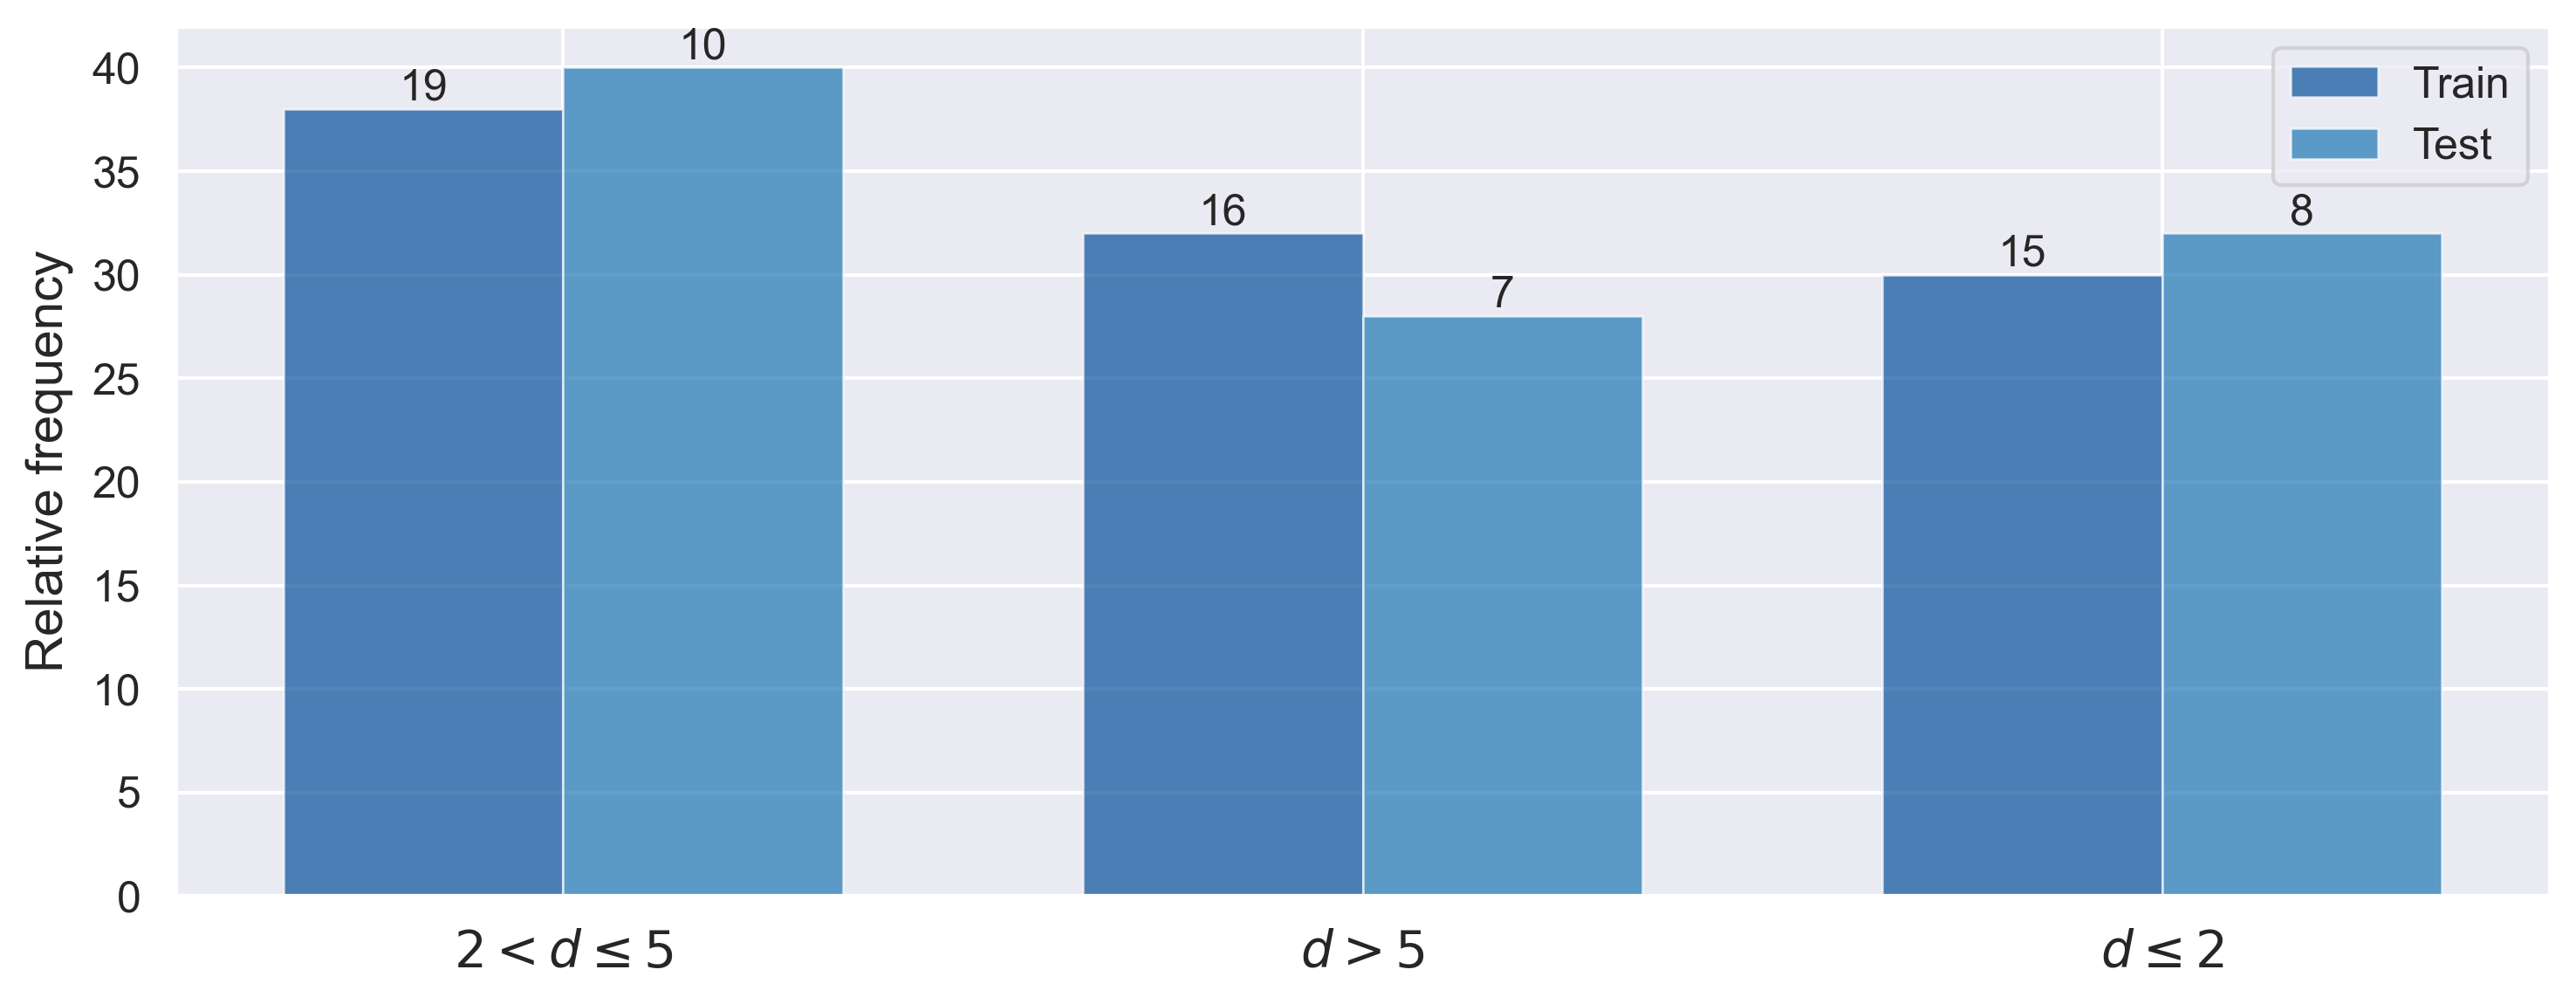

In [19]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

x = np.arange(len(df))

width = 0.35

bars_train = ax.bar(x - width/2, df["freq_train"].values, width=width, label="Train", color=train_color, alpha=0.7, edgecolor=edge_color, linewidth=0.6)
bars_test  = ax.bar(x + width/2, df["freq_test"].values,  width=width, label="Test",  color=test_color, alpha=0.7,  edgecolor=edge_color, linewidth=0.6)

ax.set_xlabel("")
ax.set_ylabel("Relative frequency", fontsize=fontsize, labelpad=5)

ax.set_xticks(x, df["bin"])
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize-2)

# ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

# ax.legend(frameon=True, fontsize=fontsize-2, title_fontsize=fontsize, title='Dataset split')
ax.legend(frameon=True, fontsize=fontsize-2)

def annotate(container, values):
    for rect, val in zip(container, values):
        h = rect.get_height()
        ax.annotate(f"{int(val)}",
                    xy=(rect.get_x() + rect.get_width()/2, h),
                    xytext=(0, 0), textcoords="offset points",
                    ha="center", va="bottom", fontsize=fontsize-2, fontweight='normal')

annotate(bars_train, df["count_train"].values)
annotate(bars_test, df["count_test"].values)

plt.tight_layout()

plt.savefig(f"{path_to_save}/target_rate_barplot.svg", dpi=600)

plt.show()

## *One-factor (OF)* analysis

### *OF*-statictics calculation

In [20]:
def of_analysis(feature, features_df_train, target_train, features_df_test, target_test, n_bootstrap=50, C=1.0, random_state=42, n_splits=3, cv_shuffle=True):

    def safe_auc(y_true, proba):
        try:
            return roc_auc_score(y_true, proba, multi_class="ovr")
        except ValueError:
            return np.nan

    def fit_logreg_and_auc(X_tr, y_tr, X_te, y_te, C=1.0, rs=42, return_scale=False):
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        clf = OneVsRestClassifier(
            LogisticRegression(
                penalty="l2", C=C, solver="lbfgs", max_iter=10_000, random_state=rs
            )
        )
        clf.fit(X_tr_s, y_tr)

        auc_train = safe_auc(y_tr, clf.predict_proba(X_tr_s))
        auc_test  = safe_auc(y_te, clf.predict_proba(X_te_s))

        if return_scale:
            return auc_train, auc_test, float(scaler.mean_[0]), float(scaler.scale_[0])
        return auc_train, auc_test

    def bootstrap_block(X_source, y_train, X_test_raw, y_test, n_bs, C, rs=42):
        aucs_train, aucs_test = [], []
        for seed in range(n_bs):
            X_bs, y_bs = resample(X_source, y_train, replace=True, random_state=seed)
            a_tr, a_te = fit_logreg_and_auc(X_bs, y_bs, X_test_raw, y_test, C=C, rs=rs)
            aucs_train.append(a_tr)
            aucs_test.append(a_te)
        return np.asarray(aucs_train, float), np.asarray(aucs_test, float)

    def cv_block(X_train_raw, y_train, n_splits, shuffle, rs, C):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=rs)
        oof_scores = []
        for tr_idx, val_idx in skf.split(X_train_raw, y_train):
            X_tr, X_val = X_train_raw[tr_idx], X_train_raw[val_idx]
            y_tr, y_val = y_train[tr_idx], y_train[val_idx]

            scaler = StandardScaler().fit(X_tr)
            X_tr_s  = scaler.transform(X_tr)
            X_val_s = scaler.transform(X_val)

            clf = OneVsRestClassifier(
                LogisticRegression(
                    penalty="l2", C=C, solver="lbfgs", max_iter=10_000, random_state=rs
                )
            )
            clf.fit(X_tr_s, y_tr)
            proba_val = clf.predict_proba(X_val_s)
            oof_scores.append(safe_auc(y_val, proba_val))

        return np.asarray(oof_scores, float)

    def summarize(arr):
        arr = np.asarray(arr, float)
        if arr.size == 0:
            return np.nan, np.nan, np.nan
        return float(np.nanmean(arr)), float(np.nanpercentile(arr, 5)), float(np.nanpercentile(arr, 95))

    rng = np.random.default_rng(random_state)

    X_train_raw = features_df_train[[feature]].values
    y_train     = target_train.values
    X_test_raw  = features_df_test[[feature]].values
    y_test      = target_test.values

    # Глобальные (единственная подгонка на всём трейне)
    auc_global_train, auc_global_test, mean_val, std_val = fit_logreg_and_auc(
        X_train_raw, y_train, X_test_raw, y_test, C=C, rs=random_state, return_scale=True
    )

    # Бутстрэп
    bs_train, bs_test = bootstrap_block(
        X_train_raw, y_train, X_test_raw, y_test, n_bs=n_bootstrap, C=C, rs=random_state
    )
    bs_mean_train, bs_ci5_train, bs_ci95_train = summarize(bs_train)
    bs_mean_test,  bs_ci5_test,  bs_ci95_test  = summarize(bs_test)

    # Нoise baseline (перемешанный train)
    shuffled_train = rng.permutation(X_train_raw.ravel()).reshape(-1, 1)
    noise_train, noise_test = bootstrap_block(
        shuffled_train, y_train, X_test_raw, y_test, n_bs=n_bootstrap, C=C, rs=random_state
    )
    noise_mean_train, noise_ci5_train, noise_ci95_train = summarize(noise_train)
    noise_mean_test,  noise_ci5_test,  noise_ci95_test  = summarize(noise_test)

    # Δ и z-score
    delta_auc_train = bs_mean_train - noise_mean_train
    delta_auc_test  = bs_mean_test  - noise_mean_test
    std_noise_train = np.nanstd(noise_train)
    std_noise_test  = np.nanstd(noise_test)
    z_score_train = (delta_auc_train / std_noise_train) if std_noise_train > 0 else np.nan
    z_score_test  = (delta_auc_test  / std_noise_test)  if std_noise_test  > 0 else np.nan

    # CV-OOF
    cv_scores = cv_block(X_train_raw, y_train, n_splits=n_splits, shuffle=cv_shuffle, rs=random_state, C=C)
    cv_mean_train, cv_ci5_train, cv_ci95_train = summarize(cv_scores)

    return {
        "Feature": feature,
        "$scale-mean$": mean_val,
        "$scale-std$": std_val,
        "$C$": C,

        "$ROC-AUC_{ovr}^{global,train}$": auc_global_train,
        "$ROC-AUC_{ovr}^{global,test}$":  auc_global_test,

        "$ROC-AUC_{ovr}^{BS,train}$": bs_mean_train,
        "$CI_{5\\%}^{BS,train}$":     bs_ci5_train,
        "$CI_{95\\%}^{BS,train}$":    bs_ci95_train,
        "$ROC-AUC_{ovr}^{BS,test}$":  bs_mean_test,
        "$CI_{5\\%}^{BS,test}$":      bs_ci5_test,
        "$CI_{95\\%}^{BS,test}$":     bs_ci95_test,

        "$ROC-AUC_{ovr}^{CV,train}$": cv_mean_train,
        "$CI_{5\\%}^{CV,train}$":     cv_ci5_train,
        "$CI_{95\\%}^{CV,train}$":    cv_ci95_train,
        "$n_{folds}^{CV}$":           int(np.isfinite(cv_scores).sum()),

        "$ROC-AUC_{ovr}^{noise,train}$": noise_mean_train,
        "$CI_{5\\%}^{noise,train}$":     noise_ci5_train,
        "$CI_{95\\%}^{noise,train}$":    noise_ci95_train,
        "$ROC-AUC_{ovr}^{noise,test}$":  noise_mean_test,
        "$CI_{5\\%}^{noise,test}$":      noise_ci5_test,
        "$CI_{95\\%}^{noise,test}$":     noise_ci95_test,

        "$ΔROC-AUC^{train}$": delta_auc_train,
        "$ΔROC-AUC^{test}$":  delta_auc_test,
        "$z-score^{train}$":  z_score_train,
        "$z-score^{test}$":   z_score_test,

        "$n_{valid}^{BS,train}$":      int(np.isfinite(bs_train).sum()),
        "$n_{valid}^{BS,test}$":       int(np.isfinite(bs_test).sum()),
        "$n_{valid}^{noise,train}$":   int(np.isfinite(noise_train).sum()),
        "$n_{valid}^{noise,test}$":    int(np.isfinite(noise_test).sum()),
    }


In [21]:
%%time

features_list = X_train.columns.tolist()

with tqdm_joblib(desc="Calculation progress", total=len(features_list)):
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(of_analysis)(
            feature,
            X_train,
            y_train,
            X_test,
            y_test,
            n_bootstrap=50,
            C=1.0,
        )
        for feature in features_list
    )

Calculation progress:   0%|          | 0/45 [00:00<?, ?it/s]

CPU times: user 95.4 ms, sys: 70.6 ms, total: 166 ms
Wall time: 2.71 s


In [22]:
of_metrics_df = pd.DataFrame(results).sort_values(
    by=[
        "$CI_{5\%}^{BS,train}$",
        "$ROC-AUC_{ovr}^{BS,train}$",
        "$ROC-AUC_{ovr}^{global,train}$"
    ],
    ascending=[
        False,
        False,
        False
    ]
)
print(of_metrics_df.shape)
of_metrics_df.head(3)

(45, 30)


,Feature,$scale-mean$,$scale-std$,$C$,"$ROC-AUC_{ovr}^{global,train}$","$ROC-AUC_{ovr}^{global,test}$","$ROC-AUC_{ovr}^{BS,train}$","$CI_{5\%}^{BS,train}$","$CI_{95\%}^{BS,train}$","$ROC-AUC_{ovr}^{BS,test}$","$CI_{5\%}^{BS,test}$","$CI_{95\%}^{BS,test}$","$ROC-AUC_{ovr}^{CV,train}$","$CI_{5\%}^{CV,train}$","$CI_{95\%}^{CV,train}$",$n_{folds}^{CV}$,"$ROC-AUC_{ovr}^{noise,train}$","$CI_{5\%}^{noise,train}$","$CI_{95\%}^{noise,train}$","$ROC-AUC_{ovr}^{noise,test}$","$CI_{5\%}^{noise,test}$","$CI_{95\%}^{noise,test}$",$ΔROC-AUC^{train}$,$ΔROC-AUC^{test}$,$z-score^{train}$,$z-score^{test}$,"$n_{valid}^{BS,train}$","$n_{valid}^{BS,test}$","$n_{valid}^{noise,train}$","$n_{valid}^{noise,test}$"
27,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",0.504191,0.174840,1.0,0.862489,0.858702,0.858528,0.794530,0.902039,0.858347,0.836258,0.874258,0.863396,0.842532,0.880909,3,0.576090,0.501923,0.670471,0.581963,0.216187,0.789813,0.282438,0.276383,5.350927,1.422006,50,50,50,50
39,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,0.762830,0.319390,1.0,0.873717,0.846836,0.857698,0.793801,0.920848,0.839645,0.807614,0.855725,0.872631,0.847677,0.901053,3,0.570791,0.523747,0.652917,0.497970,0.202053,0.797947,0.286907,0.341675,6.622192,1.574837,50,50,50,50
6,$\overline{I}_{3355 \pm 50}$,0.709293,0.281658,1.0,0.863838,0.847397,0.857370,0.790700,0.904949,0.840454,0.820730,0.861952,0.829413,0.768117,0.886299,3,0.603482,0.521780,0.679897,0.628742,0.214826,0.808397,0.253888,0.211712,4.485748,1.055484,50,50,50,50


### *Hard-check* factor selection

In [23]:
of_features_to_save = (
    of_metrics_df
    .loc[
        (of_metrics_df['$CI_{5\%}^{BS,train}$'] >= 0.60)
        # & (of_metrics_df['$CI_{5\%}^{CV,train}$'] >= 0.55)
        & (of_metrics_df['$ROC-AUC_{ovr}^{global,train}$'] >= 0.60)
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(of_metrics_df["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(of_metrics_df["Feature"].unique()) * 100, 2)}%',
    sep='\n'
)

Число фичей
(*) до отбора: 45
(*) после отбора: 37
Доля фичей, прошедших однофакторный отбор: 82.22%


In [24]:
of_metrics_df = of_metrics_df.loc[of_metrics_df['Feature'].isin(of_features_to_save)]

print(of_metrics_df.shape)
of_metrics_df.head(3)

(37, 30)


,Feature,$scale-mean$,$scale-std$,$C$,"$ROC-AUC_{ovr}^{global,train}$","$ROC-AUC_{ovr}^{global,test}$","$ROC-AUC_{ovr}^{BS,train}$","$CI_{5\%}^{BS,train}$","$CI_{95\%}^{BS,train}$","$ROC-AUC_{ovr}^{BS,test}$","$CI_{5\%}^{BS,test}$","$CI_{95\%}^{BS,test}$","$ROC-AUC_{ovr}^{CV,train}$","$CI_{5\%}^{CV,train}$","$CI_{95\%}^{CV,train}$",$n_{folds}^{CV}$,"$ROC-AUC_{ovr}^{noise,train}$","$CI_{5\%}^{noise,train}$","$CI_{95\%}^{noise,train}$","$ROC-AUC_{ovr}^{noise,test}$","$CI_{5\%}^{noise,test}$","$CI_{95\%}^{noise,test}$",$ΔROC-AUC^{train}$,$ΔROC-AUC^{test}$,$z-score^{train}$,$z-score^{test}$,"$n_{valid}^{BS,train}$","$n_{valid}^{BS,test}$","$n_{valid}^{noise,train}$","$n_{valid}^{noise,test}$"
27,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",0.504191,0.174840,1.0,0.862489,0.858702,0.858528,0.794530,0.902039,0.858347,0.836258,0.874258,0.863396,0.842532,0.880909,3,0.576090,0.501923,0.670471,0.581963,0.216187,0.789813,0.282438,0.276383,5.350927,1.422006,50,50,50,50
39,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,0.762830,0.319390,1.0,0.873717,0.846836,0.857698,0.793801,0.920848,0.839645,0.807614,0.855725,0.872631,0.847677,0.901053,3,0.570791,0.523747,0.652917,0.497970,0.202053,0.797947,0.286907,0.341675,6.622192,1.574837,50,50,50,50
6,$\overline{I}_{3355 \pm 50}$,0.709293,0.281658,1.0,0.863838,0.847397,0.857370,0.790700,0.904949,0.840454,0.820730,0.861952,0.829413,0.768117,0.886299,3,0.603482,0.521780,0.679897,0.628742,0.214826,0.808397,0.253888,0.211712,4.485748,1.055484,50,50,50,50


### Mapping features with their types

In [25]:
rows = []

for _, row in of_metrics_df.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

of_metrics_expanded_df = pd.DataFrame(rows)

print(of_metrics_expanded_df.shape)
of_metrics_expanded_df.head(3)

(74, 31)


,Feature,$scale-mean$,$scale-std$,$C$,"$ROC-AUC_{ovr}^{global,train}$","$ROC-AUC_{ovr}^{global,test}$","$ROC-AUC_{ovr}^{BS,train}$","$CI_{5\%}^{BS,train}$","$CI_{95\%}^{BS,train}$","$ROC-AUC_{ovr}^{BS,test}$","$CI_{5\%}^{BS,test}$","$CI_{95\%}^{BS,test}$","$ROC-AUC_{ovr}^{CV,train}$","$CI_{5\%}^{CV,train}$","$CI_{95\%}^{CV,train}$",$n_{folds}^{CV}$,"$ROC-AUC_{ovr}^{noise,train}$","$CI_{5\%}^{noise,train}$","$CI_{95\%}^{noise,train}$","$ROC-AUC_{ovr}^{noise,test}$","$CI_{5\%}^{noise,test}$","$CI_{95\%}^{noise,test}$",$ΔROC-AUC^{train}$,$ΔROC-AUC^{test}$,$z-score^{train}$,$z-score^{test}$,"$n_{valid}^{BS,train}$","$n_{valid}^{BS,test}$","$n_{valid}^{noise,train}$","$n_{valid}^{noise,test}$",Feature_Type
27,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",0.504191,0.17484,1.0,0.862489,0.858702,0.858528,0.794530,0.902039,0.858347,0.836258,0.874258,0.863396,0.842532,0.880909,3,0.576090,0.501923,0.670471,0.581963,0.216187,0.789813,0.282438,0.276383,5.350927,1.422006,50,50,50,50,engineered_features_intervals_3800_2500
27,"$\frac{I_{2928}}{\Sigma I_{p,\ 3800\text{–}2500}}$",0.504191,0.17484,1.0,0.862489,0.858702,0.858528,0.794530,0.902039,0.858347,0.836258,0.874258,0.863396,0.842532,0.880909,3,0.576090,0.501923,0.670471,0.581963,0.216187,0.789813,0.282438,0.276383,5.350927,1.422006,50,50,50,50,engineered_features
39,$\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 50}}$,0.762830,0.31939,1.0,0.873717,0.846836,0.857698,0.793801,0.920848,0.839645,0.807614,0.855725,0.872631,0.847677,0.901053,3,0.570791,0.523747,0.652917,0.497970,0.202053,0.797947,0.286907,0.341675,6.622192,1.574837,50,50,50,50,engineered_features_intervals_3800_2500


### Visualization

In [26]:
train_color = "#08519c"
test_color  = "#1f77b4"

PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18, 'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14, 'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 8, 'X_NBINS': 8,
    'BAR_HEIGHT': 0.34, 'BAR_ALPHA': 0.7,
    'FIG_DPI': 300, 'SUBPLOT_WIDTH': 6, 'SUBPLOT_HEIGHT': 4.2,
    'TOP_N': 5, 'LEGEND_FONT_SIZE': 12, 'ERR_CAPSIZE': 3, 'ERR_LINEWIDTH': 1.4,
    'HUE_COLORS': {'train': train_color, 'test': test_color}
}

KEYS = {
    'bs_train': "$ROC-AUC_{ovr}^{BS,train}$",     'glob_train': "$ROC-AUC_{ovr}^{global,train}$",
    'bs_test': "$ROC-AUC_{ovr}^{BS,test}$",       'glob_test': "$ROC-AUC_{ovr}^{global,test}$",
    'ci5_train': "$CI_{5\\%}^{BS,train}$",        'ci95_train': "$CI_{95\\%}^{BS,train}$",
    'ci5_test': "$CI_{5\\%}^{BS,test}$",          'ci95_test': "$CI_{95\\%}^{BS,test}$",
    'cv_train': '$ROC-AUC_{ovr}^{CV,train}$',     'ci5_cv_train': '$CI_{5\%}^{CV,train}$',
    'ci95_cv_train': '$CI_{95\%}^{CV,train}$'
}

VISUAL_TYPE_LABELS = {'peaks': 'Peak-based', 'intervals': 'Region-based'}

In [27]:
def extract_base_and_range(feature_type: str):
    if not isinstance(feature_type, str):
        return None, None

    parts = feature_type.lower().split('_')

    # база (тип)
    if 'peaks' in parts:
        base = 'peaks'
    elif 'intervals' in parts:
        base = 'intervals'
    else:
        base = None

    # диапазон — две последние числовые части
    nums = [p for p in parts if re.fullmatch(r'\d+(?:\.\d+)?', p)]
    rng = None
    if len(nums) >= 2:
        a, b = float(nums[-2]), float(nums[-1])
        hi, lo = (max(a, b), min(a, b))
        def _fmt(x):
            xi = int(round(x))
            return str(xi) if abs(x - xi) < 1e-9 else f"{x:g}"
        rng = f"{_fmt(hi)}–{_fmt(lo)}"

    # валидируем базу по словарю визуальных меток
    if base not in VISUAL_TYPE_LABELS:
        base = None

    return base, rng


def group_sort_key(gr):
    base, rng = gr
    base_order = list(VISUAL_TYPE_LABELS.keys())
    base_idx = base_order.index(base) if base in base_order else len(base_order)

    hi = lo = None
    if isinstance(rng, str):
        m = re.findall(r'\d+(?:\.\d+)?', rng)
        if len(m) >= 2:
            a, b = float(m[0]), float(m[1])
            hi, lo = (max(a, b), min(a, b))

    # hi -> сортируем по убыванию (поэтому минус), lo -> по возрастанию
    return (base_idx, -(hi if hi is not None else -1e9), (lo if lo is not None else 1e9))


def panel_title_from_group(gr):
    base, rng = gr
    base_label = VISUAL_TYPE_LABELS.get(base, base or "")
    return f"{base_label} | {rng} cm$^{{-1}}$" if rng else base_label


def build_plot_df(subset: pd.DataFrame, top_n: int = 5):
    rows = []
    for _, row in subset.iterrows():
        feat = row.get('Feature')
        if pd.isna(feat):
            continue

        for split in ('train', 'test'):
            mean_col_bs = KEYS[f'bs_{split}']
            mean_col_glob = KEYS[f'glob_{split}']
            ci5_col = KEYS[f'ci5_{split}']
            ci95_col = KEYS[f'ci95_{split}']

            mean = row.get(mean_col_bs)
            ci5  = row.get(ci5_col)
            ci95 = row.get(ci95_col)

            # если bootstrap-метрик нет — используем global без ошибок
            if pd.isna(mean):
                mean = row.get(mean_col_glob)
                ci5, ci95 = np.nan, np.nan

            if pd.isna(mean):
                continue

            err_left  = float(mean - ci5)  if (ci5  is not None and not pd.isna(ci5))  else 0.0
            err_right = float(ci95 - mean) if (ci95 is not None and not pd.isna(ci95)) else 0.0

            rows.append({
                'Feature': feat,
                'Split': split,
                'mean': float(mean),
                'err_left': err_left,
                'err_right': err_right
            })

    plot_df = pd.DataFrame(rows)
    if plot_df.empty:
        return plot_df, []

    order_feats = (
        plot_df.groupby('Feature')['mean']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )
    plot_df = plot_df[plot_df['Feature'].isin(order_feats)].copy()
    return plot_df, order_feats


In [28]:
tmp = of_metrics_expanded_df.copy()

tmp[['viz_base','viz_range']] = tmp['Feature_Type'].apply(lambda s: pd.Series(extract_base_and_range(s)))
tmp = tmp[tmp['viz_base'].isin(VISUAL_TYPE_LABELS) & tmp['viz_range'].notna()]

present_groups = sorted(tmp[['viz_base','viz_range']].drop_duplicates().itertuples(index=False, name=None), key=group_sort_key)

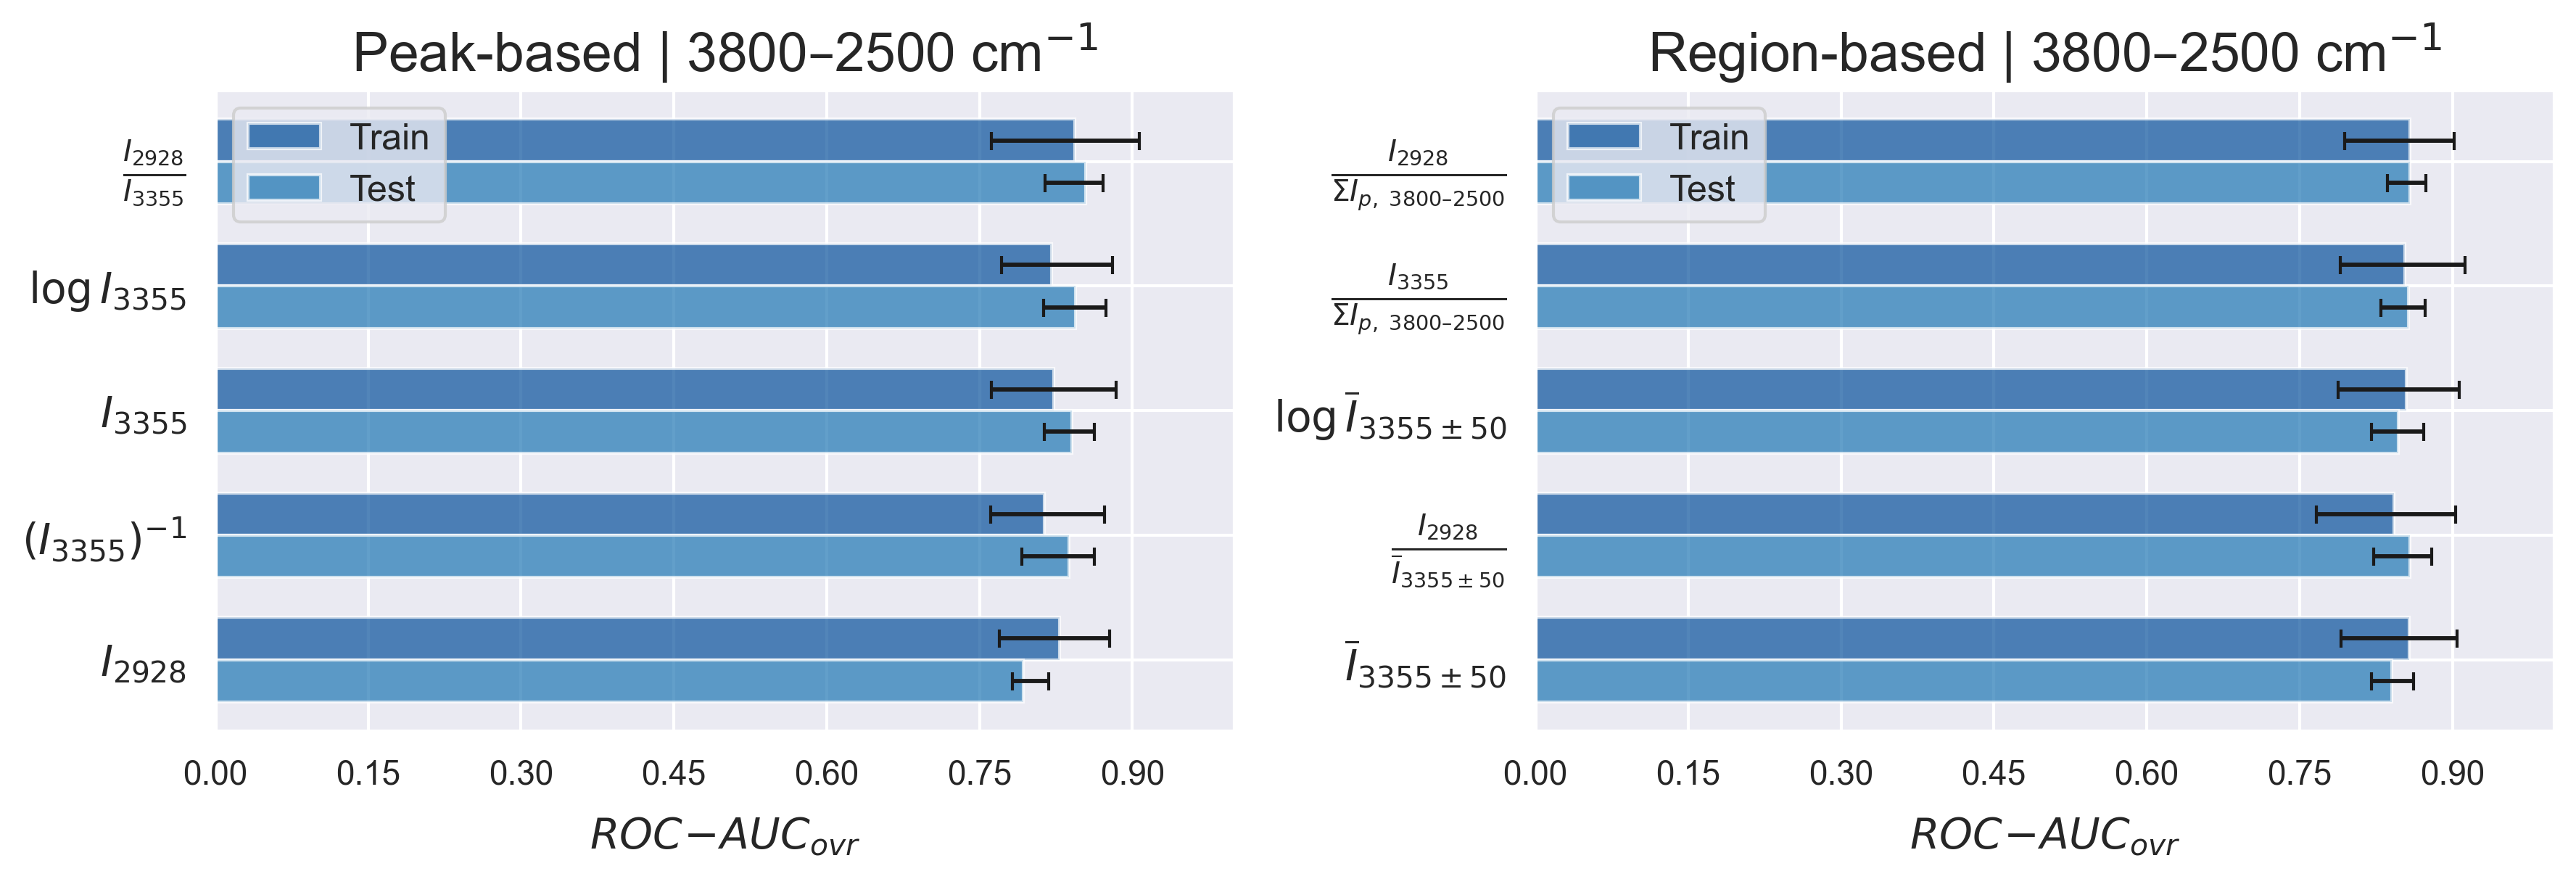

In [29]:
# --- layout ---
n = len(present_groups)
ncols = 2 if n > 1 else 1
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols*PLOT_STYLE['SUBPLOT_WIDTH'], nrows*PLOT_STYLE['SUBPLOT_HEIGHT']),
                         dpi=PLOT_STYLE['FIG_DPI'])
axes = np.atleast_1d(axes).ravel()

# --- panels ---
for i, g in enumerate(present_groups):
    ax = axes[i]
    base, rng = g
    subset = tmp[(tmp['viz_base']==base) & (tmp['viz_range']==rng)].copy()
    plot_df, order_feats = build_plot_df(subset, PLOT_STYLE['TOP_N'])
    if plot_df.empty:
        ax.set_title(panel_title_from_group(g), fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                     fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
        ax.text(0.5,0.5,'no data',ha='center',va='center',fontsize=12,alpha=0.7)
        ax.set_axis_off()
        continue

    plot_df['Feature'] = pd.Categorical(plot_df['Feature'], categories=order_feats, ordered=True)
    y0 = np.arange(len(order_feats)); off = PLOT_STYLE['BAR_HEIGHT']/2

    for split, sign in (('train',-1),('test',+1)):
        sub = plot_df[plot_df['Split']==split].sort_values('Feature')
        y = y0 + sign*off
        xerr = np.vstack([sub['err_left'].to_numpy(), sub['err_right'].to_numpy()])
        ax.barh(y, sub['mean'], height=PLOT_STYLE['BAR_HEIGHT'], alpha=PLOT_STYLE['BAR_ALPHA'],
                label=split.capitalize(), color=PLOT_STYLE['HUE_COLORS'][split],
                xerr=xerr, error_kw={'capsize':PLOT_STYLE['ERR_CAPSIZE'], 'lw':PLOT_STYLE['ERR_LINEWIDTH']})

    ax.set_yticks(y0, labels=order_feats, fontsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    ax.invert_yaxis()
    ax.set_xlabel('$ROC\\!-\\!AUC_{ovr}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'],
                  labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_xlim(0,1)
    ax.set_title(panel_title_from_group(g), fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                 fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))
    ax.legend(loc='upper left', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)

# hide unused axes
for j in range(len(present_groups), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_auc_barplots.svg')

plt.show()

## *Multi-factor* analysis

### Functions for processing & config-parameters

#### Forward selection

In [30]:
def forward_selection_bootstrap(
    X_train: pd.DataFrame,
    y_train: pd.Series | np.ndarray,
    X_test: pd.DataFrame,
    y_test: pd.Series | np.ndarray,
    candidate_features: list[str],
    scoring: str = "roc_auc_ovr",          # 'roc_auc_ovr' | 'pr_auc'
    min_uplift: float | None = None,
    max_features: int | None = None,
    n_bootstrap: int = 50,
    n_jobs: int = -1,
    use_tqdm: bool = True,
    uplift_type: str = "mean",             # 'mean' | 'low' | 'high' — USED ONLY WHEN selection_mode='bootstrap'
    return_ci: bool = True,                # kept for compatibility; CI is always calculated in bootstrap mode
    random_state: int = 42,
    selection_mode: str = "bootstrap",     # 'bootstrap' | 'train'
):
    rng = np.random.RandomState(random_state)

    # convert targets to arrays/indices
    y_tr = np.asarray(y_train).ravel() if isinstance(y_train, (pd.Series, pd.DataFrame)) else np.asarray(y_train).ravel()
    y_te = np.asarray(y_test).ravel() if isinstance(y_test, (pd.Series, pd.DataFrame)) else np.asarray(y_test).ravel()

    # fix the set of classes (important for PR AUC / aligning probability column order)
    classes = np.unique(np.concatenate([y_tr, y_te]))

    def _score_metric(y_true, proba):
        try:
            if scoring == "roc_auc_ovr":
                return roc_auc_score(y_true, proba, multi_class="ovr", labels=classes)
            elif scoring == "pr_auc":
                y_bin = label_binarize(y_true, classes=classes)
                return average_precision_score(y_bin, proba, average="macro")
            else:
                raise ValueError(f"Unsupported metric: {scoring}")
        except Exception:
            return np.nan

    # Общий пайплайн обучение→прогноз→метрика
    def _fit_and_score(Xtr, ytr, Xte, seed):
        est = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", OneVsRestClassifier(
                LogisticRegression(
                    penalty="l2",
                    C=1.0,
                    solver="lbfgs",
                    max_iter=10_000,
                    random_state=seed
                ),
                n_jobs=None
            ))
        ])
        est.fit(Xtr, ytr)
        proba_tr = est.predict_proba(Xtr)
        proba_te = est.predict_proba(Xte)
        if hasattr(est, "classes_"):
            order = [int(np.where(est.classes_ == c)[0][0]) for c in classes]
            proba_tr = proba_tr[:, order]
            proba_te = proba_te[:, order]
        train_metric = _score_metric(ytr, proba_tr)
        test_metric  = _score_metric(y_te, proba_te)
        return train_metric, test_metric

    selected: list[str] = []
    best_train_score = -np.inf
    history: list[dict] = []
    remain = list(candidate_features)

    # --- режим 1: bootstrap (как было) ---
    def bootstrap_scores(feature_set: list[str]):
        Xtr = X_train[feature_set].values
        Xte = X_test[feature_set].values

        def single_bootstrap(seed: int):
            idx = resample(np.arange(len(y_tr)), replace=True, random_state=seed)
            X_bs = Xtr[idx]
            y_bs = y_tr[idx]
            if np.unique(y_bs).size < 2:
                return np.nan, np.nan
            try:
                return _fit_and_score(X_bs, y_bs, Xte, seed)
            except Exception:
                return np.nan, np.nan

        seeds = rng.randint(0, 10**9, size=n_bootstrap)
        pairs = Parallel(n_jobs=n_jobs)(
            delayed(single_bootstrap)(int(s)) for s in seeds
        )
        pairs = np.asarray(pairs, dtype=float)
        train_scores = pairs[:, 0]
        test_scores  = pairs[:, 1]

        def _agg(x):
            return (np.nanmean(x), np.nanpercentile(x, 5), np.nanpercentile(x, 95))

        tr_mean, tr_low, tr_high = _agg(train_scores)
        te_mean, te_low, te_high = _agg(test_scores)
        return (tr_mean, tr_low, tr_high), (te_mean, te_low, te_high)

    # --- режим 2: plain train (без бутстрапа) ---
    def plain_train_scores(feature_set: list[str]):
        Xtr = X_train[feature_set].values
        Xte = X_test[feature_set].values
        try:
            tr, te = _fit_and_score(Xtr, y_tr, Xte, random_state)
        except Exception:
            tr, te = np.nan, np.nan
        # совместимость с полями *_mean/low/high
        return (tr, tr, tr), (te, te, te)

    step = 0
    while remain:
        step += 1
        iterator = tqdm(remain, desc=f"Step {step}") if use_tqdm else remain

        if selection_mode not in ("bootstrap", "train"):
            raise ValueError("selection_mode must be 'bootstrap' or 'train'")

        scorer = bootstrap_scores if selection_mode == "bootstrap" else plain_train_scores

        results = Parallel(n_jobs=n_jobs)(
            delayed(scorer)(selected + [feat]) for feat in iterator
        )

        candidates_info = []
        for feat, ((tr_m, tr_l, tr_h), (te_m, te_l, te_h)) in zip(remain, results):
            candidates_info.append({
                "feature":   feat,
                "train_mean": float(tr_m),
                "train_low":  float(tr_l),
                "train_high": float(tr_h),
                "test_mean":  float(te_m),
                "test_low":   float(te_l),
                "test_high":  float(te_h),
            })

        # ключ выбора
        if selection_mode == "bootstrap":
            if uplift_type == "mean":
                key = "train_mean"
            elif uplift_type == "low":
                key = "train_low"
            elif uplift_type == "high":
                key = "train_high"
            else:
                raise ValueError("uplift_type must be one of: 'mean', 'low', 'high'")
        else:
            # в train-режиме берем train_mean (он же = low = high)
            key = "train_mean"

        best_candidate = max(candidates_info, key=lambda x: (x[key], -np.inf if np.isnan(x[key]) else 0))

        uplift = best_candidate[key] - best_train_score
        if (min_uplift is not None) and (uplift < min_uplift):
            break

        selected.append(best_candidate["feature"])
        remain.remove(best_candidate["feature"])
        best_train_score = best_candidate[key]

        history.append({
            "feature":     best_candidate["feature"],
            "train_mean":  best_candidate["train_mean"],
            "train_low":   best_candidate["train_low"],
            "train_high":  best_candidate["train_high"],
            "test_mean":   best_candidate["test_mean"],
            "test_low":    best_candidate["test_low"],
            "test_high":   best_candidate["test_high"],
            "uplift_train": float(uplift),
            "n_selected":  len(selected),
            "selection_mode": selection_mode,   # NEW: для прозрачности в логе
        })

        if (max_features is not None) and (len(selected) >= max_features):
            break

    return selected, history

#### *Metric-uplift* line plot

In [31]:
def plot_cumulative_score_line_bootstrap(
    selection_log,
    ax=None,
    show_ci=True,
    show_test=True,
    annotate=True,
):
    # Prepare data
    df_log = pd.DataFrame(selection_log).copy()
    if df_log.empty:
        raise ValueError("selection_log is empty.")

    # Backward compatibility with old keys
    if {"score_mean", "score_low", "score_high"}.issubset(df_log.columns):
        df_log["train_mean"] = df_log["score_mean"]
        df_log["train_low"]  = df_log["score_low"]
        df_log["train_high"] = df_log["score_high"]

    req_train = {"train_mean", "train_low", "train_high"}
    if not req_train.issubset(df_log.columns):
        missing = req_train - set(df_log.columns)
        raise ValueError(f"Missing train columns: {missing}")

    df_log["Step"] = np.arange(1, len(df_log) + 1)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(max(6, len(df_log) * 1.2), 5), dpi=150)
        created_fig = True

    # Style from PLOT_STYLE (direct access)
    title           = PLOT_STYLE["TITLE"]
    title_fs        = PLOT_STYLE["TITLE_FONT_SIZE"]
    title_fs_style  = PLOT_STYLE["TITLE_FONTSTYLE"]
    x_label         = PLOT_STYLE["X_LABEL"]
    x_label_fs      = PLOT_STYLE["X_LABEL_FONT_SIZE"]
    x_labelpad      = PLOT_STYLE["X_LABELPAD"]
    y_label         = PLOT_STYLE["Y_LABEL"]
    y_label_fs      = PLOT_STYLE["Y_LABEL_FONT_SIZE"]
    y_labelpad      = PLOT_STYLE["Y_LABELPAD"]
    x_tick_fs       = PLOT_STYLE["X_TICK_LABEL_FONT_SIZE"]
    y_tick_fs       = PLOT_STYLE["Y_TICK_LABEL_FONT_SIZE"]
    metric_value_fs = PLOT_STYLE["METRIC_VALUE_FONT_SIZE"]

    # Fixed colors
    train_color = "#08519c"
    test_color  = "#1f77b4"

    # Train line
    line_train, = ax.plot(
        df_log["Step"],
        df_log["train_mean"],
        marker="o",
        linewidth=2,
        alpha=0.7,
        linestyle="-",
        label="Train",
        color=train_color,
    )
    if show_ci:
        ax.fill_between(
            df_log["Step"],
            df_log["train_low"],
            df_log["train_high"],
            alpha=0.20,
            color=train_color,
        )

    # Test line (nominal)
    line_test = None
    if show_test and {"test_mean","test_low","test_high"}.issubset(df_log.columns):
        line_test, = ax.plot(
            df_log["Step"],
            df_log["test_mean"],
            marker="s",
            linewidth=2,
            alpha=0.7,
            linestyle="-",
            label="Test",
            color=test_color,
        )
        if show_ci:
            ax.fill_between(
                df_log["Step"],
                df_log["test_low"],
                df_log["test_high"],
                alpha=0.20,
                color=test_color,
            )

    # Point annotations
    if annotate:
        for _, row in df_log.iterrows():
            ax.text(
                row["Step"],
                row["train_mean"] + 0.005,
                f'{row["train_mean"]:.3f}',
                ha="center",
                va="bottom",
                fontsize=metric_value_fs,
                color='black',
            )
        if line_test is not None:
            for _, row in df_log.iterrows():
                ax.text(
                    row["Step"],
                    row["test_mean"] - 0.020,
                    f'{row["test_mean"]:.3f}',
                    ha="center",
                    va="bottom",
                    fontsize=metric_value_fs,
                    color='black',
                )

    # Axes formatting
    ax.set_title(title, fontsize=title_fs, fontstyle=title_fs_style)
    ax.set_xlabel(x_label, fontsize=x_label_fs, labelpad=x_labelpad)
    ax.set_ylabel(y_label, fontsize=y_label_fs, labelpad=y_labelpad)
    ax.tick_params(axis="x", labelsize=x_tick_fs)
    ax.tick_params(axis="y", labelsize=y_tick_fs)

    # Exactly 10 ticks on Y
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))

    # Steps and labels
    ax.set_xticks(df_log["Step"])
    if "feature" in df_log.columns:
        ax.set_xticklabels(df_log["feature"], rotation=0)

    # Legend with only two line entries
    handles = [line_train] + ([line_test] if line_test is not None else [])
    labels = ["Train"] + (["Test"] if line_test is not None else [])
    ax.legend(handles, labels, loc="upper left", frameon=True)

    # Y limits padding
    y_candidates = [df_log["train_low"], df_log["train_high"], df_log["train_mean"]]
    if line_test is not None:
        y_candidates += [df_log["test_low"], df_log["test_high"], df_log["test_mean"]]
    y_min = np.nanmin([c.min() for c in y_candidates])
    y_max = np.nanmax([c.max() for c in y_candidates])
    if np.isfinite(y_min) and np.isfinite(y_max):
        pad = (y_max - y_min) * 0.06 if y_max > y_min else 0.02
        ax.set_ylim(y_min - pad, y_max + pad)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax

### Feature selection

In [32]:
candidate_features = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        candidate_features.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features)}')

Число фичей для многофакторного анализа: 74


In [33]:
%%time

selected_feats, selection_log = forward_selection_bootstrap(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    candidate_features=candidate_features,
    scoring='roc_auc_ovr',
    min_uplift=0.005,
    max_features=3,
    n_bootstrap=50,
    uplift_type='low',  # 'mean', 'low', 'high'
    n_jobs=-1
)

Step 1:   0%|          | 0/74 [00:00<?, ?it/s]

Step 2:   0%|          | 0/73 [00:00<?, ?it/s]

Step 3:   0%|          | 0/72 [00:00<?, ?it/s]

CPU times: user 331 ms, sys: 54.6 ms, total: 386 ms
Wall time: 6.99 s


In [34]:
PLOT_STYLE = {
    'TITLE': '',
    'TITLE_FONT_SIZE': 12,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 16,
    'Y_TICK_LABEL_FONT_SIZE': 10,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'METRIC_VALUE_FONT_SIZE': 8,
    'Y_NBINS': 10
}

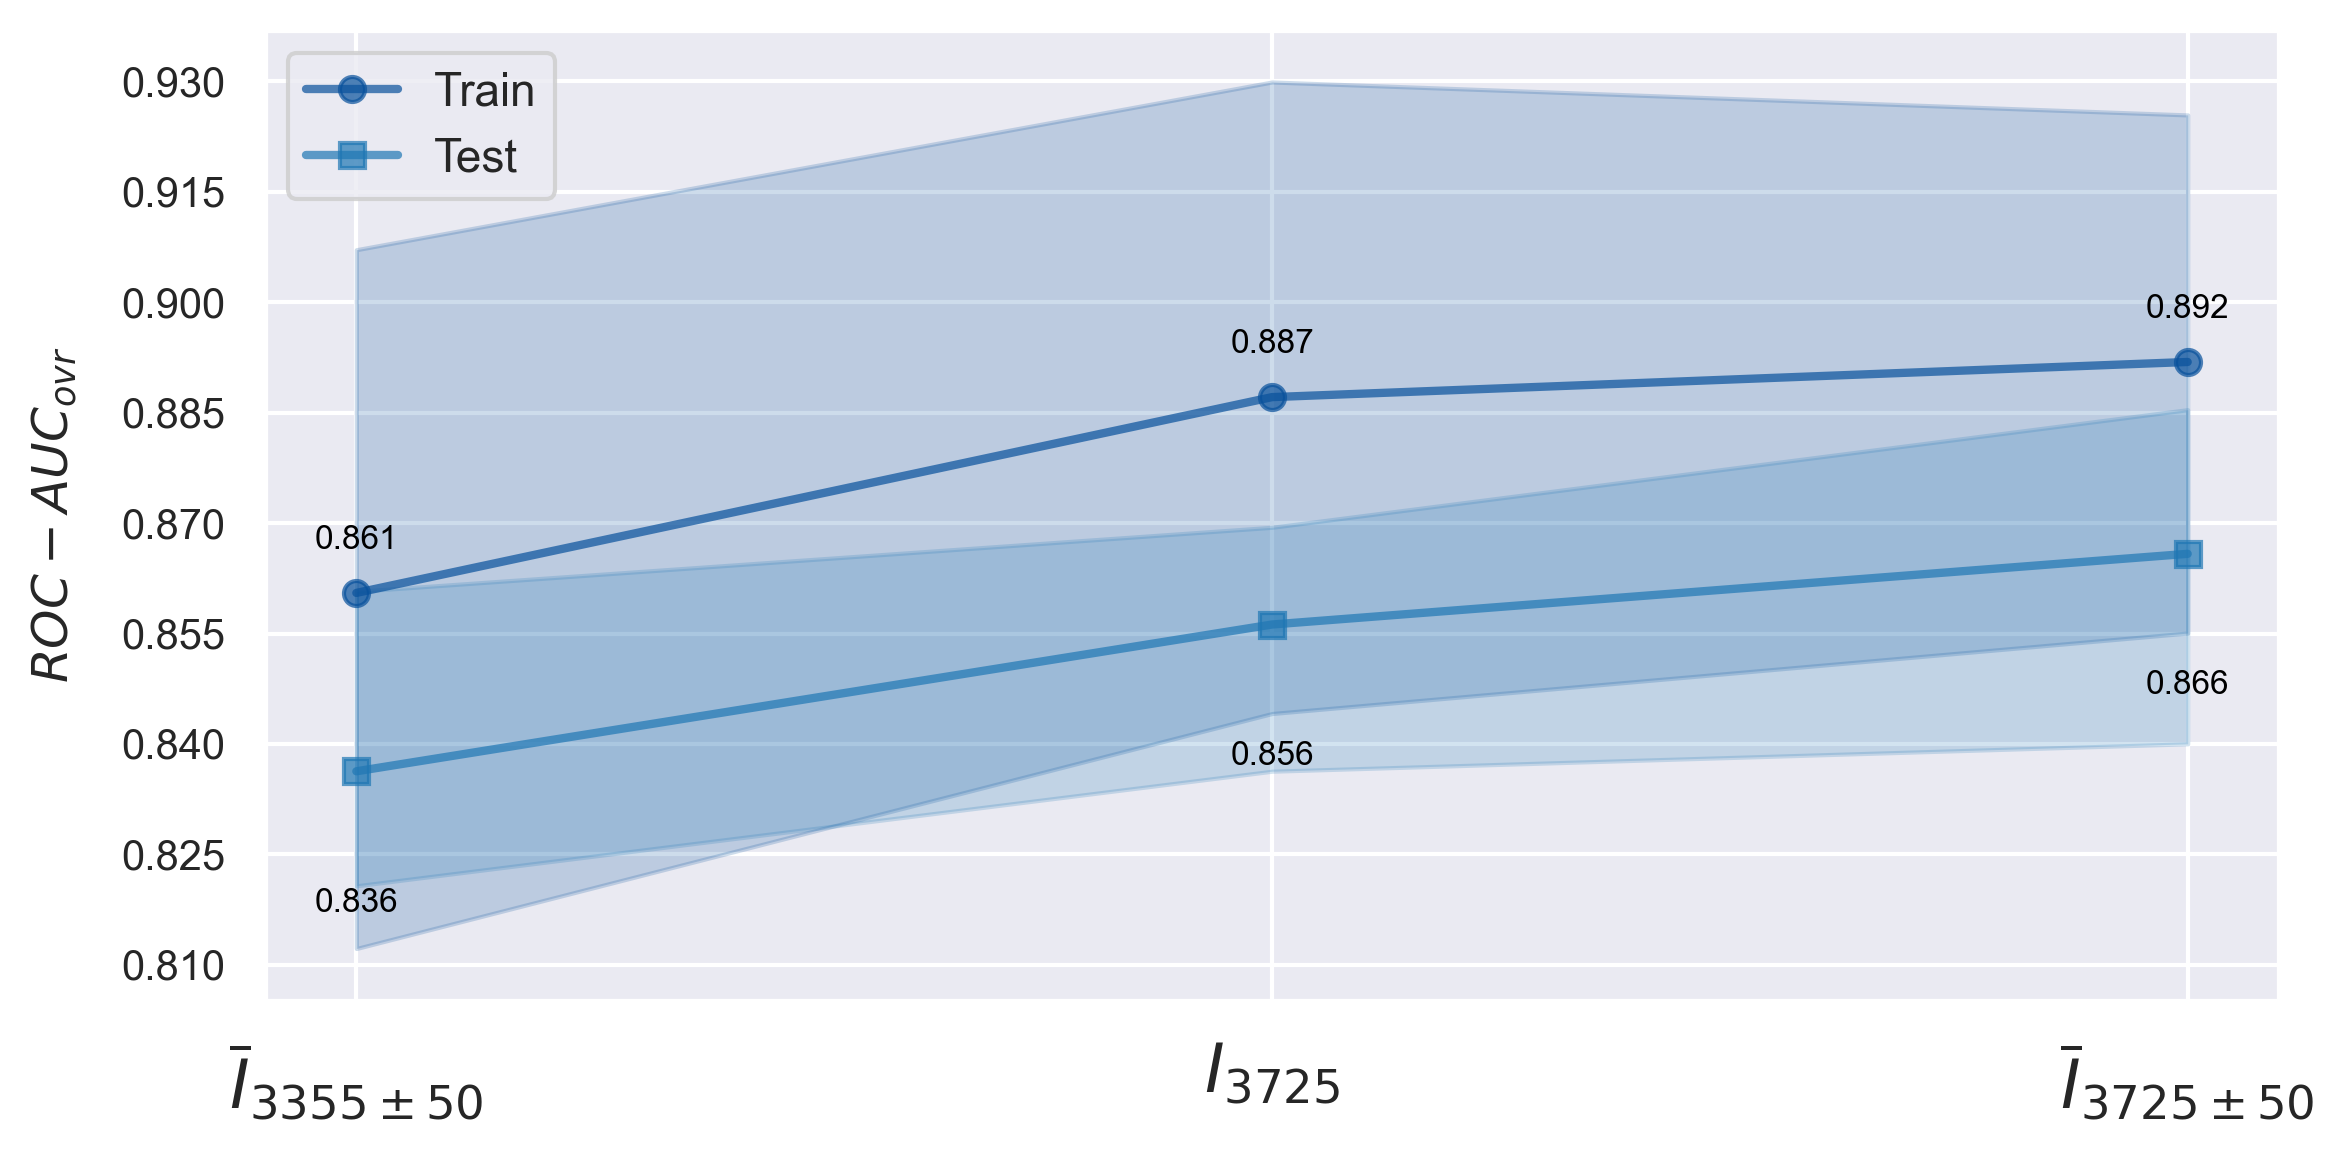

In [35]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

plot_cumulative_score_line_bootstrap(
    selection_log=selection_log,
    ax=ax,
    show_ci=True
)

plt.tight_layout()
plt.savefig(f'{path_to_save}/fs_uplift_lineplot_bootstrap.svg', dpi=600)
plt.show()